In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data


import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row


Bad key savefig.frameon in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [4]:
PREFIX = 'COSMOS'

In [5]:
lsbg_cat = Table.read(f'./Catalog/{PREFIX}/{PREFIX.lower()}_cutout_cat_{PREFIX}.fits')
lsbg_cat.sort('viz-id')

### The measurement is done by running `sbatch 1k_meas.slurm`, etc. Check `vanilla_measure_all.py` for details.

The measurement catalogs are saved at `./Catalog/NSA/z002_004/lsbg_measure_vaniila_XXXXX.fits`.

Below, we combine these catalogs together.

In [6]:
meas_cat = Table.read(f'./Catalog/{PREFIX}/_lsbg_measure_vanilla.fits')

In [7]:
len(meas_cat[(~np.isnan(meas_cat['ID']))])

373

### Analysis

In [8]:
import kuaizi
import pickle
from astropy.cosmology import Planck15
cosmos = Planck15
h = cosmos.h
kuaizi.set_matplotlib(style='nature', usetex=False)

In [9]:
junk = (lsbg_cat['bad_votes'] > lsbg_cat['good_votes'])
candy = (lsbg_cat['good_votes'] > lsbg_cat['bad_votes']) & (lsbg_cat['is_candy'] > lsbg_cat['is_galaxy'])
gal = (~junk) & (~candy)

In [14]:
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

In [15]:
print('Candy:', np.sum(candy))
print('Gal:', np.sum(gal))
print('Junk:', np.sum(junk))

Candy: 48
Gal: 135
Junk: 190


In [16]:
from kuaizi.display import plot_measurement

# of Candy: 48
# of Gal: 135
# of Junk: 190


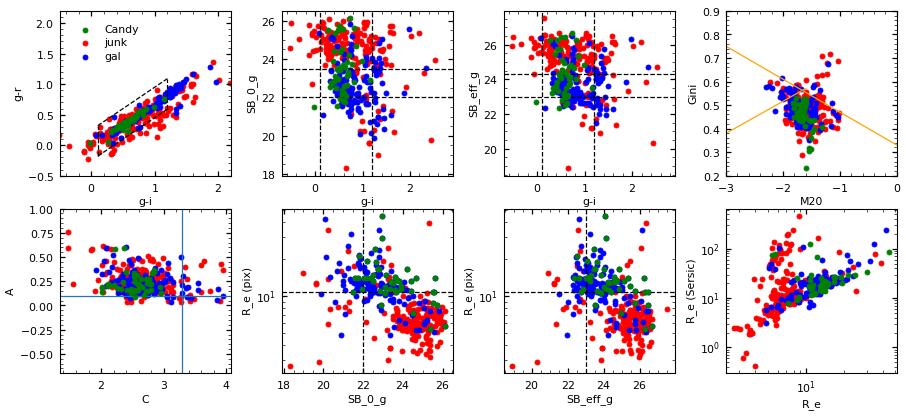

In [17]:
plot_measurement(lsbg_cat, meas_cat)

In [18]:
color_bound = [0.1, 1.2]
half_width = 0.25

mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)

mask &= (meas_cat['rhalf_circularized'] > 1.6 / 0.168) & (meas_cat['rhalf_circularized'] < 12 / 0.168)# & (meas_cat['r20'] > 1 / 0.168)
#mask &= (meas_cat['rhalf_ellip'] > 1.8 / 0.168) & (meas_cat['rhalf_ellip'] < 12 / 0.168)

mask &= (meas_cat['SB_0'][:, 0] > 22.0)

#mask &= (meas_cat['SB_eff_ellip'][:, 2] > 23.8) # Cuts based on JL votes
#mask &= (meas_cat['SB_eff_ellip'][:, 2] > 23.) # Cuts based on JG votes
mask &= (meas_cat['SB_eff_avg'][:, 0] > 23.0) # Cuts based on JG votes

mask &= (meas_cat['ell_sym'] < 0.65)

mask &= (meas_cat['M20'] < -1.1)
mask &= (meas_cat['Gini'] < 0.7)
mask &= ~((meas_cat['M20'] < -1.6) & (
    meas_cat['Gini'] > meas_cat['M20'] * 0.136 + 0.788) & (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.33))

mask &= (meas_cat['C'] < 3.5)
#mask &= (meas_cat['A_outer'] <= 0.13)


print('Candy:', np.sum(mask & candy))
print('Gal:', np.sum(mask & gal))
print('Junk:', np.sum(mask & junk))

Candy: 34
Gal: 48
Junk: 4


# of Candy: 34
# of Gal: 48
# of Junk: 4


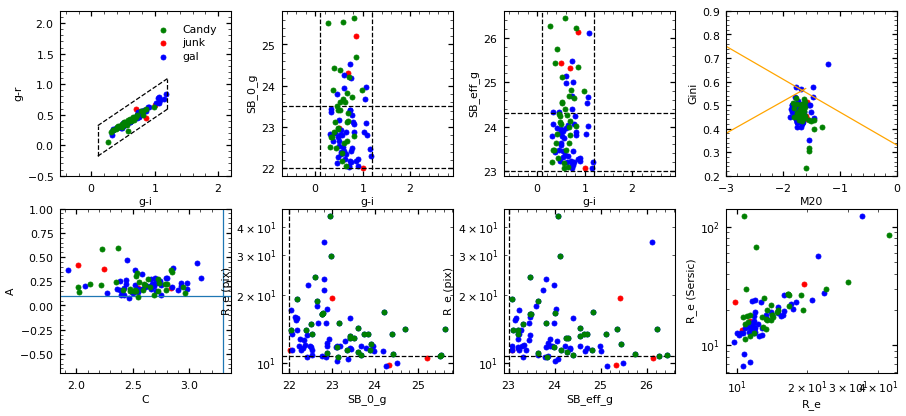

In [19]:
plot_measurement(lsbg_cat[mask], meas_cat[mask])

### Save catalog

In [20]:
from astropy.table import hstack
hstack([lsbg_cat[mask], meas_cat[mask]]
      ).write('./Catalog/COSMOS/lsbg_COSMOS_after_cuts_JG.fits', overwrite=True)

In [21]:
cuts_cat = Table.read('./Catalog/COSMOS/lsbg_COSMOS_after_cuts_JG.fits')

In [23]:
pwd

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [22]:
cuts_cat

ra,dec,a_image,b_image,theta_image,ellipticity,mag_auto_g,mag_auto_r,mag_auto_i,flux_radius_ave_g,flux_radius_ave_i,mu_ave_g,mu_ave_i,acorr_ratio,g-i,g-r,A_g,A_r,A_i,tract,patch,synth_id,viz-id,is_candy,is_galaxy,is_tidal,is_outskirts,is_cirrus,is_junk,num_votes,good_votes,bad_votes,cutout_size,prefix,radius,image_flag [5],psf_flag [5],ID,flux [4],mag [4],SB_0 [4],SB_eff_circ [4],SB_eff_ellip [4],SB_eff_avg [4],xc_cen,yc_cen,xc_sym,yc_sym,ell_cen,ell_sym,PA_cen,PA_sym,rhalf_circ,rhalf_ellip,rhalf_circularized,r20,r50,r80,Gini,M20,"F(G,M20)","S(G,M20)",C,A,A_outer,A_shape,S,sersic_n,sersic_rhalf,sersic_ell,sersic_PA,sersic_xc,sersic_yc,sersic_amp,flag,flag_sersic
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcmin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes3,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,bytes63,float64,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
150.3456186,1.7934761,24.698,10.159,-38.16,0.589,19.0966,18.8951,18.8088,4.358592,4.276776,23.817403471286855,23.487988624712163,1.1900577735900615,0.27887760039057835,0.2017727782027049,0.051231112601542735,0.03630389080424819,0.02590871299211951,9813,"3,2",-1,1203,2,0,0,0,0,0,2,2,0,0.7,/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/COSMOS/cosmos_1203,0.7,True .. True,True .. True,1203.0,1264.185302734375 .. 1900.864501953125,19.245473861694336 .. 18.802621841430664,22.7642822265625 .. 22.321430206298828,24.521703720092773 .. 24.078853607177734,24.14671516418457 .. 23.70386505126953,23.468612670898438 .. 23.0257625579834,89.9507308170123,87.12720455076634,88.81264652168464,89.78179486739151,0.5622870575676961,0.560644182601002,-0.6470582171881515,-0.6549657791572961,18.849210516624634,24.843916245817898,16.46752180054727,8.850170454328838,18.674738521704494,32.84936370980303,0.5260689443164592,-1.6259957896469326,-0.2291436434082028,-0.03220515988762901,2.8478766321347915,0.3491910616950822,0.4720645563242049,0.0,0.04430285248653643,0.9090618927376715,27.167238852177608,0.6883170184306929,2.56403188497437,89.88824432112051,89.76255663307379,0.46397390488466483,0.0,0.0
149.461417,1.6749434,14.092,6.362,-32.73,0.549,20.5501,20.2475,20.1752,2.5876200000000003,2.3846760000000002,24.029565130544253,23.513198666760385,1.3330667240042375,0.38934792820480957,0.30153000523712953,0.054123559520550396,0.03835356475768047,0.027371487725363408,9813,"8,1",-1,2773,2,0,0,0,0,0,2,2,0,0.7,/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/COSMOS/cosmos_2773,0.7,True .. True,True .. True,2773.0,380.3836975097656 .. 625.8629760742188,20.54944610595703 .. 20.00880241394043,23.128143310546875 .. 22.587501525878906,24.741270065307617 .. 24.200626373291016,24.45680809020996 .. 23.91616439819336,23.83740234375 .. 23.29676055908203,61.9212761731699,58.44022313401258,61.09626801042656,58.88039073770316,0.5618877524722463,0.562760730035307,-0.5627687221695535,-0.5624003492776439,11.634131597519932,16.07376805942826,10.628629723814813,5.706736560244185,11.617088215926778,20.65238998867562,0.4735259515163766,-1.623250491880692,-0.49113394912061636,-0.08384112637020341,2.7929124636846083,0.16361877155028073,0.22070437614535102,0.0,0.05037629842990641,0.9984962747285634,17.266091412093484,0.674548791464415,2.5179297718560667,60.41177660703155,59.30021884680639,0.33129472314817554,0.0,0.0
149.8118098,2.1923005,15.324,7.306,54.08,0.523,20.2583,19.9916,19.8668,2.7571320000000004,2.63424,23.845131945648912,23.39028966390057,1.3136434055087005,0.36972057488803,0.2707654452719193,0.056404368827910494,0.039969814099827694,0.028524943715939888,9813,"6,4",-1,2850,2,0,0,0,

In [71]:
udg_cat = Table.read('./Catalog/NSA/z002_004/UDG_NSA_MW_z002_004_JG.fits')

In [85]:
inds = np.random.randint(0, len(udg_cat), len(cuts_cat))

In [86]:
ang_diam_dist = udg_cat['host_ang_diam_dist'][inds] # not consider peculiar motion

rhalf_phys = cuts_cat['rhalf_circularized'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
cuts_cat['rhalf_circularized_phys'] = rhalf_phys

rhalf_phys = cuts_cat['rhalf_ellip'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
cuts_cat['rhalf_ellip_phys'] = rhalf_phys

In [87]:
cuts_cat['abs_mag'] = cuts_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # ugri
BV = 0.62 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) + 0.15
V = cuts_cat['mag'][:, 0] - 0.52 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) - 0.03
V_abs = V - 25 - 5 * np.log10(ang_diam_dist)
log_ML_V = 1.493 * BV - 0.681
M = (4.83 - V_abs) / (2.5) + log_ML_V
cuts_cat['log_m_star'] = M

In [88]:
### UDGs
flag = (cuts_cat['rhalf_circularized_phys'] > 1.3) & (cuts_cat['SB_0'][:, 0] >= 24.5)# & (cuts_cat['sersic_ell'] < 0.7)
print('# of UDGs:', np.sum(flag))

# of UDGs: 1


In [104]:
UDG_num = []
for i in range(100):
    inds = np.random.randint(0, len(udg_cat), len(cuts_cat))
    ang_diam_dist = udg_cat['host_ang_diam_dist'][inds] # not consider peculiar motion

    rhalf_phys = cuts_cat['rhalf_circularized'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
    cuts_cat['rhalf_circularized_phys'] = rhalf_phys

    rhalf_phys = cuts_cat['rhalf_ellip'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
    cuts_cat['rhalf_ellip_phys'] = rhalf_phys
    cuts_cat['abs_mag'] = cuts_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # ugri
    BV = 0.62 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) + 0.15
    V = cuts_cat['mag'][:, 0] - 0.52 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) - 0.03
    V_abs = V - 25 - 5 * np.log10(ang_diam_dist)
    log_ML_V = 1.493 * BV - 0.681
    M = (4.83 - V_abs) / (2.5) + log_ML_V
    cuts_cat['log_m_star'] = M
    ### UDGs
    flag = (cuts_cat['rhalf_circularized_phys'] > 1.3) & (cuts_cat['SB_0'][:, 0] >= 24.5)# & (cuts_cat['sersic_ell'] < 0.7)
    
    UDG_num.append(np.sum(flag))

In [105]:
np.mean(UDG_num), np.std(UDG_num)

(2.36, 0.7002856560004638)

In [99]:
len(cuts_cat)

76

In [1]:
2.36 / 76

0.031052631578947366

In [2]:
0.7 / 76

0.009210526315789473